In [27]:
from pydrake.examples.acrobot import (AcrobotGeometry, AcrobotInput,
                                      AcrobotPlant, AcrobotState, AcrobotParams)
from pydrake.all import Linearize, LinearQuadraticRegulator, SymbolicVectorSystem, Variable, Saturation, \
WrapToSystem, Simulator, Polynomial

from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

from IPython.display import SVG, display
import pydot
import numpy as np
import math
import control

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import pydrake.forwarddiff as pf
import time

from IPython.display import display, Math, Markdown
from pydrake.examples.pendulum import PendulumPlant
from pydrake.examples.acrobot import AcrobotPlant
from pydrake.all import MultibodyPlant, Parser, SinCos, MakeVectorVariable, ToLatex, Substitute, Box
from underactuated import FindResource
from underactuated.scenarios import AddShape

from pydrake.all import (Jacobian, MathematicalProgram, Polynomial,
                         RegionOfAttraction, RegionOfAttractionOptions, Solve,
                         SymbolicVectorSystem, ToLatex, Variable, Variables,
                         plot_sublevelset_expression, AddMultibodyPlantSceneGraph, SolverOptions, 
                         CommonSolverOption)

from pydrake.solvers.mosek import MosekSolver
import sympy as sp
from sympy.physics.vector import dynamicsymbols as dynamicsymbols

In [28]:
from IPython.display import display, Math
from pydrake.examples.pendulum import PendulumPlant
from pydrake.examples.acrobot import AcrobotPlant
from pydrake.all import MultibodyPlant, Parser, SinCos, MakeVectorVariable, ToLatex, Substitute, Box
from underactuated import FindResource
from underactuated.scenarios import AddShape


def PrintImplicitPolynomialDynamics(plant,
                                    context,
                                    sincos_indices):
    sym_plant = plant.ToSymbolic()
    sym_context = sym_plant.CreateDefaultContext()
    sym_context.SetTimeStateAndParametersFrom(context)
    sym_plant.FixInputPortsFrom(plant, context, sym_context)

    state = sym_context.get_continuous_state()
    derivatives = sym_context.Clone().get_mutable_continuous_state()

    q = MakeVectorVariable(state.num_q(), "q")
    v = MakeVectorVariable(state.num_v(), "v")
    qd = MakeVectorVariable(state.num_q(), "\dot{q}")
    vd = MakeVectorVariable(state.num_v(), "\dot{v}")

    state.SetFromVector(np.hstack((q, v)))
    derivatives.SetFromVector(np.hstack((qd, vd)))
    residual = sym_plant.CalcImplicitTimeDerivativesResidual(
        sym_context, derivatives)
        
    s = MakeVectorVariable(state.num_q(), "s")
    c = MakeVectorVariable(state.num_q(), "c")
    subs = {}
    for i in sincos_indices:
        subs[q[i]] = SinCos(s[i], c[i])
    
    dynamics = Substitute(residual, subs)
    dynamics = residual

    display(Markdown("$"+ToLatex(dynamics, 2) + "= 0$"))
    
    return dynamics, q, v, qd, vd, s, c


plant = MultibodyPlant(0.0)
Parser(plant).AddModelFromFile(FindResource('models/cartpole.urdf'))
plant.Finalize()
context = plant.CreateDefaultContext()
plant.get_actuation_input_port().FixValue(context, [0])
indices = [1]
dynamics, q, v, qd, vd, s, c = PrintImplicitPolynomialDynamics(plant, context, indices)

$\begin{bmatrix} ( - v_{0} + \dot{q}_{0}) \\ ( - v_{1} + \dot{q}_{1}) \\ (110\dot{v}_{0} - 50v_{1}^{2} \sin{q_{1}} + 50\dot{v}_{1} \cos{q_{1}}) \\ (250\dot{v}_{1} + 50\dot{v}_{0} \cos{q_{1}} + 490.50\sin{q_{1}}) \end{bmatrix}= 0$

In [29]:
state = np.array([q[0], q[1], v[0], v[1]])
state = np.hstack([q, v])
state_dot = np.array([qd[0], qd[1], vd[0], vd[1]])
state_dot = np.hstack([qd, vd])

env = {q[0]:0, q[1]:np.pi, v[0]:0, v[1]:0, qd[0]:0, qd[1]:0, vd[0]:0, vd[1]:0}

A_general = []
for exp in dynamics: 
    exp_curr = exp.Jacobian(state)
    A_general.append(exp_curr)
A_general = np.array(A_general)  

A = np.zeros_like(A_general)
for i, row in enumerate(A_general): 
    for j, elem in enumerate(row): 
        A[i, j] = elem.Evaluate(env)
        
A = np.array(A, dtype=float)
A = -A


E_general = []
for exp in dynamics: 
    exp_curr = exp.Jacobian(state_dot)
    E_general.append(exp_curr)
E_general = np.array(E_general)  

E = np.zeros_like(E_general)
for i, row in enumerate(E_general): 
    for j, elem in enumerate(row): 
        E[i, j] = elem.Evaluate(env)
        
E = np.array(E, dtype=float)


In [30]:
A

array([[ -0. ,  -0. ,   1. ,  -0. ],
       [ -0. ,  -0. ,  -0. ,   1. ],
       [ -0. ,  -0. ,  -0. ,   0. ],
       [ -0. , 490.5,  -0. ,  -0. ]])

In [31]:
E

array([[  1.,   0.,   0.,   0.],
       [  0.,   1.,   0.,   0.],
       [  0.,   0., 110., -50.],
       [  0.,   0., -50., 250.]])

In [32]:
x = Variable("x")
theta = Variable("t")
xdot = Variable("\dot{x}")
thetadot = Variable("\dot{t}")
u_symbolic = Variable("u")
garbage = Variable("garbage")

x = np.hstack([x, theta, xdot, thetadot])

In [47]:
mp = 1
mc = 10
l = 0.5
gravity = 9.8

In [48]:
M = np.array([[1, 0, 0, 0], 
             [0, 1, 0, 0], 
             [0, 0, mc+mp, l*mp*pf.cos(theta)], 
             [0, 0, l*mp*pf.cos(theta), l**2*mp]])

E = np.array([[1, 0, 0, 0], 
             [0, 1, 0, 0], 
             [0, 0, mc+mp, -l*mp], 
             [0, 0, -l*mp, l**2*mp]])

A = np.array([[0, 0, 1, 0], 
             [0, 0, 0, 1], 
             [0, 0, 0, 0], 
             [0, gravity*l*mp, 0, 0]])

B = np.array([[0], [0], [1], [0]])

Q = np.diag([10, 10, 1, 1])
R = [1]

X, L, K = control.care(A, B, Q, R, E=E)

In [49]:
A

array([[0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 1. ],
       [0. , 0. , 0. , 0. ],
       [0. , 4.9, 0. , 0. ]])

In [50]:
B

array([[0],
       [0],
       [1],
       [0]])

In [51]:
E

array([[ 1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , 11.  , -0.5 ],
       [ 0.  ,  0.  , -0.5 ,  0.25]])

In [52]:
A_cloop = A - B@K
Q_lyap = np.eye(4)

P = control.lyap(A_cloop.T, Q_lyap, E=E.T)

np.linalg.eigvals(P)

array([1.36807619e+02, 1.21675789e-03, 1.30066976e+00, 1.14835442e+00])

In [53]:
K

array([[ -3.16227766, 254.15443856,  -9.76993902,  55.1540753 ]])

In [54]:
K_casted = np.insert(K, 2, 0)
K_casted

array([ -3.16227766, 254.15443856,   0.        ,  -9.76993902,
        55.1540753 ])

In [55]:
X

array([[ 3.08952599e+01, -1.74412500e+02, -3.16227766e+00,
        -1.64021817e+02],
       [-1.74412500e+02,  6.96558599e+03,  2.54154439e+02,
         6.59025292e+03],
       [-3.16227766e+00,  2.54154439e+02,  1.00538212e+01,
         2.40723944e+02],
       [-1.64021817e+02,  6.59025292e+03,  2.40723944e+02,
         6.23823732e+03]])

In [56]:
K2 = B.T@X@M

In [57]:
K2

array([[-3.162277660170612, 254.15443856098466,
        <Expression "(110.59203274637555 + 120.3619717674303 * cos(t))">,
        <Expression "(60.180985883715152 + 5.026910579380707 * cos(t))">]],
      dtype=object)

HI
[-2.   3.6  0.   0.   0. ]
[-7.67490165e-08  3.14159250e+00  3.83255417e-06  7.72583383e-06]
[7.67490165e-08 1.54714204e-07 3.83255417e-06 7.72583383e-06]
[ True  True  True  True]
3.141592498875589


<IPython.core.display.Javascript object>


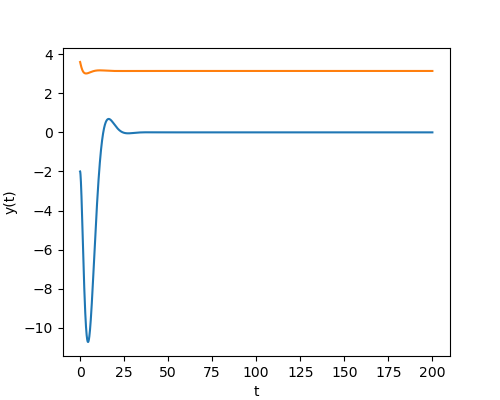

In [44]:
# testing both the controllers
def UprightState():
    return np.array([0, np.pi, 0, 0])

print('HI')
# defining the controller

u = -K@(x  - UprightState())
own_controller = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u)

u2 = -K2@(x - UprightState())
own_controller_new = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u2)

l = 0.5
#defining the system
exp_dynamics = np.array([xdot, 
                         thetadot, 
                         (1/(mc+mp*(pf.sin(theta))**2))*(u_symbolic + \
                                            mp*pf.sin(theta)*(l*thetadot**2+gravity*pf.cos(theta))),
                         (1/(l*mc+l*mp*(pf.sin(theta))**2))*(-u_symbolic*pf.cos(theta) \
                                -mp*l*thetadot**2*pf.cos(theta)*pf.sin(theta)-(mc+mp)*gravity*pf.sin(theta))])
system = SymbolicVectorSystem(state=x, input=[u_symbolic], dynamics=exp_dynamics, output=x)



builder = DiagramBuilder()
# plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.1)
# file_name = FindResource("models/cartpole.urdf")
# Parser(plant).AddModelFromFile(file_name)
# plant.Finalize()
# print('Plant Finalised')

plant = builder.AddSystem(system)
wrapangles = WrapToSystem(4)
wrapangles.set_interval(1, 0, 2*np.pi)
wrapto = builder.AddSystem(wrapangles)
builder.Connect(plant.get_output_port(0), wrapto.get_input_port(0))
controller = builder.AddSystem(own_controller_new)
builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0),
                plant.get_input_port())

logger = LogVectorOutput(plant.get_output_port(), builder)

diagram = builder.Build()

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
context = simulator.get_mutable_context()
#plant_context = plant.GetMyMutableContextFromRoot(context)

# Simulate
simulator.set_target_realtime_rate(0)
duration = 200

for i in range(1):
    context.SetTime(0.)
#     plant.SetPositionsAndVelocities(
#         plant_context,
#         UprightState() + 0.9 * np.random.randn(4,))
    trial = np.append(UprightState(), 0) - 0.1*np.random.randn(5)
    trial = np.array([-2, 3.6, 0, 0, 0])
    print(trial)
    context.SetContinuousState(trial)
    simulator.Initialize()
    simulator.AdvanceTo(duration)
    
    log = logger.FindLog(context)
    
    end_state = log.data()[:, -1]
    print(end_state)
    diff = np.abs(end_state - UprightState())
    print(diff)
    print(diff < np.ones(4)*5e-2)
    print(log.data()[1][-1])
    plt.figure(figsize=(5, 4))
    plt.plot(log.sample_times(), log.data().transpose()[:, :2])
    plt.xlabel('t')
    plt.ylabel('y(t)')

In [62]:
# def find_implicit_V(B, X, S, V): 
prog = MathematicalProgram()
x_p = prog.NewIndeterminates(1, "x")
t = prog.NewIndeterminates(1, "t")
x_pd = prog.NewIndeterminates(1, "\dot{x}")
td = prog.NewIndeterminates(1, "\dot{t}")
s = prog.NewIndeterminates(1, "s")
c = prog.NewIndeterminates(1, "c")

x = np.hstack([x_p, s, c, x_pd, td])
x_0 = np.array([0, 0, -1, 0, 0])
z = np.hstack([x_p, t, x_pd, td])

M44 = np.array([[1, 0, 0, 0], 
             [0, 1, 0, 0], 
             [0, 0, mc+mp, l*mp*c[0]], 
             [0, 0, l*mp*c[0], l**2*mp]])

Mdot44 = np.array([[0, 0, 0, 0], 
             [0, 0, 0, 0], 
             [0, 0, 0, -l*mp*s[0]*td[0]], 
             [0, 0, -l*mp*s[0]*td[0], 0]])

Vz = Polynomial(z.T@M44.T@P@M44@z)

V = 0
for m, coeff in Vz.monomial_to_coefficient_map().items(): 
    #display(Markdown("$ thing(x)="+ToLatex(coeff*m.ToExpression(), 9)+"$"))
    monomial = coeff
    for i in range(1, 3): 
        d = m.degree(x[i])
        monomial *= x[i]**d
    for i in range(len(z)):
        d = m.degree(z[i])
        if i==0:
            monomial*=x[0]**d
        if i==1:
            if d == 1:
                monomial *= -x[1]
            elif d == 2:
                monomial *= (2+2*x[2])
        elif i==2 or i==3:
            monomial *= x[i+1]**d
    #display(Markdown("$ thing_changed(x)="+ToLatex(monomial, 9)+"$"))
    V += monomial

V = Polynomial(V).RemoveTermsWithSmallCoefficients(1e-5)

K2 = B.T@X@M44
u = -K2@z

fz = np.array([x_pd[0], 
              td[0], 
              mp*l*td[0]**2*s[0] + u[0],
              -mp*gravity*l*s[0]])

Vdotz = fz.T@P@M44@z + z.T@Mdot44.T@P@M44@z + z.T@M44.T@P@Mdot44@z + z.T@M44.T@P@fz
Vdotz = Polynomial(Vdotz)

Vdot = 0
for m, coeff in Vdotz.monomial_to_coefficient_map().items(): 
    #display(Markdown("$ thing(x)="+ToLatex(coeff*m.ToExpression(), 9)+"$"))
    monomial = coeff
    for i in range(1, 3): 
        d = m.degree(x[i])
        monomial *= x[i]**d
    for i in range(len(z)):
        d = m.degree(z[i])
        if i==0:
            monomial*=x[0]**d
        if i==1:
            if d == 1:
                monomial *= -x[1]
            elif d == 2:
                monomial *= (2+2*x[2])
        elif i==2 or i==3:
            monomial *= x[i+1]**d
    #display(Markdown("$ thing_changed(x)="+ToLatex(monomial, 9)+"$"))
    Vdot += monomial
Vdot = Polynomial(Vdot).RemoveTermsWithSmallCoefficients(1e-5)

s_deg = max(V.TotalDegree()-2, 0)
lambda_trig = prog.NewFreePolynomial(Variables(x), s_deg)
lambda_, lambda_Q = prog.NewSosPolynomial(Variables(x), 4)
#lambda_ = prog.NewFreePolynomial(Variables(x), 6)

trig = Polynomial(x[1]**2 + x[2]**2)

eps = 1e-5
rho = 39422.5
rho = 4155.5
rho = 179

prog.AddSosConstraint(-Vdot - eps*Polynomial((x-x_0).dot(x-x_0)) +\
                      lambda_trig*trig+ \
                      lambda_*(V - rho))

options = SolverOptions()
options.SetOption(CommonSolverOption.kPrintFileName, './check_solver_cartpole.txt')
options.SetOption(MosekSolver().solver_id(), "MSK_IPAR_NUM_THREADS", 0)


solver = MosekSolver()
result = solver.Solve(prog, solver_options=options)

assert result.is_success(), str(result.get_solver_details().solution_status)

print(rho)

179


In [123]:
env = {x_p[0]:0, s[0]:0, c[0]:-1, x_pd[0]:0, td[0]:0}

V.Evaluate(env)

0.0

In [124]:
prog2 = MathematicalProgram()
prog2.AddIndeterminates(x)

lambda_check_2 = prog2.NewFreePolynomial(Variables(x), 3)

trig = Polynomial(x[1]**2 + x[2]**2)
eps=1e-5
prog2.AddSosConstraint(V  - eps*Polynomial((x-x_0).dot(x-x_0)) \
                       + lambda_check_2*trig)

solver = MosekSolver()
result2 = solver.Solve(prog2)

assert result2.is_success(), str(result2.get_solver_details().solution_status)

In [125]:
a1 = Vdot.Jacobian(x)

Vdot_Hessian = []
for element in a1: 
    Vdot_Hessian.append(element.Jacobian(x))
Vdot_Hessian = np.array(Vdot_Hessian)

env = {x_p[0]:0, s[0]:0, c[0]:-1, x_pd[0]:0, td[0]:0}

Vdot_Hessian_origin = np.zeros_like(Vdot_Hessian)

for i in range(len(Vdot_Hessian)): 
    for j in range(len(Vdot_Hessian[i])): 
        Vdot_Hessian_origin[i, j] = Vdot_Hessian[i, j].Evaluate(env)
        
Vdot_Hessian_origin = np.array(Vdot_Hessian_origin, dtype=float)

np.linalg.eigvals(Vdot_Hessian_origin)

array([ 5.24114752e+03, -4.04763904e+03,  3.94551733e+01, -5.15681080e+00,
        0.00000000e+00])

In [67]:
Polynomial(u[0]).TotalDegree()

2

In [78]:
# def find_implicit_V(B, X, S, V): 
prog = MathematicalProgram()
x_p = prog.NewIndeterminates(1, "x")
t = prog.NewIndeterminates(1, "t")
x_pd = prog.NewIndeterminates(1, "\dot{x}")
td = prog.NewIndeterminates(1, "\dot{t}")
s = prog.NewIndeterminates(1, "s")
c = prog.NewIndeterminates(1, "c")

x = np.hstack([x_p, s, c, x_pd, td])
x_0 = np.array([0, 0, -1, 0, 0])
z = np.hstack([x_p, t, x_pd, td])

M44 = np.array([[1, 0, 0, 0], 
             [0, 1, 0, 0], 
             [0, 0, mc+mp, l*mp*c[0]], 
             [0, 0, l*mp*c[0], l**2*mp]])

Mdot44 = np.array([[0, 0, 0, 0], 
             [0, 0, 0, 0], 
             [0, 0, 0, -l*mp*s[0]*td[0]], 
             [0, 0, -l*mp*s[0]*td[0], 0]])

Vz = Polynomial(z.T@E.T@P@E@z)

V = 0
for m, coeff in Vz.monomial_to_coefficient_map().items(): 
    #display(Markdown("$ thing(x)="+ToLatex(coeff*m.ToExpression(), 9)+"$"))
    monomial = coeff
    for i in range(1, 3): 
        d = m.degree(x[i])
        monomial *= x[i]**d
    for i in range(len(z)):
        d = m.degree(z[i])
        if i==0:
            monomial*=x[0]**d
        if i==1:
            if d == 1:
                monomial *= -x[1]
            elif d == 2:
                monomial *= (2+2*x[2])
        elif i==2 or i==3:
            monomial *= x[i+1]**d
    #display(Markdown("$ thing_changed(x)="+ToLatex(monomial, 9)+"$"))
    V += monomial

V = Polynomial(V).RemoveTermsWithSmallCoefficients(1e-5)

K2 = B.T@X@M44
u = -K2@z

fz = np.array([x_pd[0], 
              td[0], 
              mp*l*td[0]**2*s[0] + u[0],
              -mp*gravity*l*s[0]])

Vdotz = z.T@A_cloop.T@P@E@z + z.T@E.T@P@A_cloop@z

Vdotz = Polynomial(Vdotz)

Vdot = 0
for m, coeff in Vdotz.monomial_to_coefficient_map().items(): 
    #display(Markdown("$ thing(x)="+ToLatex(coeff*m.ToExpression(), 9)+"$"))
    monomial = coeff
    for i in range(1, 3): 
        d = m.degree(x[i])
        monomial *= x[i]**d
    for i in range(len(z)):
        d = m.degree(z[i])
        if i==0:
            monomial*=x[0]**d
        if i==1:
            if d == 1:
                monomial *= -x[1]
            elif d == 2:
                monomial *= (2+2*x[2])
        elif i==2 or i==3:
            monomial *= x[i+1]**d
    #display(Markdown("$ thing_changed(x)="+ToLatex(monomial, 9)+"$"))
    Vdot += monomial
Vdot = Polynomial(Vdot).RemoveTermsWithSmallCoefficients(1e-5)

s_deg = max(V.TotalDegree()-2, 0)
lambda_trig = prog.NewFreePolynomial(Variables(x), s_deg)
lambda_, lambda_Q = prog.NewSosPolynomial(Variables(x), 4)
#lambda_ = prog.NewFreePolynomial(Variables(x), 6)

trig = Polynomial(x[1]**2 + x[2]**2)

eps = 1e-5
rho = 100000

prog.AddSosConstraint(-Vdot - eps*Polynomial((x-x_0).dot(x-x_0)) +\
                      lambda_trig*trig+ \
                      lambda_*(V - rho))

options = SolverOptions()
options.SetOption(CommonSolverOption.kPrintFileName, './check_solver_cartpole.txt')
options.SetOption(MosekSolver().solver_id(), "MSK_IPAR_NUM_THREADS", 0)


solver = MosekSolver()
result = solver.Solve(prog, solver_options=options)

assert result.is_success(), str(result.get_solver_details().solution_status)

print(rho)

100000


In [102]:
# def find_implicit_V(B, X, S, V): 
prog = MathematicalProgram()
x_p = prog.NewIndeterminates(1, "x")
t = prog.NewIndeterminates(1, "t")
x_pd = prog.NewIndeterminates(1, "\dot{x}")
td = prog.NewIndeterminates(1, "\dot{t}")
s = prog.NewIndeterminates(1, "s")
c = prog.NewIndeterminates(1, "c")

x = np.hstack([x_p, s, c, x_pd, td])
x_0 = np.array([0, 0, -1, 0, 0])
z = np.hstack([x_p, t, x_pd, td])


xd = prog.NewIndeterminates(5, 'xd')

u = -K_casted@(x - x_0)

g0 = Polynomial(xd[0] - x[3])
g1 = Polynomial(xd[1] - x[2]*x[4])
g2 = Polynomial(xd[2] + x[1]*x[4])
# g3 = Polynomial((mc + mp)*xd[3] + mp*l*xd[4]*x[2] - mp*l*x[4]**2*x[1] - u)
# g4 = Polynomial(mp*l*xd[3]*x[2] + mp*l**2*xd[4] + mp*gravity*l*x[1])
g3 = Polynomial((mc + mp*x[1]**2)*xd[3] - u - mp*x[1]*(l*x[4]**2 + gravity*x[2]))
g4 = Polynomial(l*(mc + mp*x[1]**2)*xd[4] + u*x[2] + mp*l*x[4]**2*x[2]*x[1] + (mc + mp)*gravity*x[1])

g = np.array([g0, g1, g2, g3, g4])

Vz = Polynomial(z.T@E.T@P@E@z)

V = 0
for m, coeff in Vz.monomial_to_coefficient_map().items(): 
    #display(Markdown("$ thing(x)="+ToLatex(coeff*m.ToExpression(), 9)+"$"))
    monomial = coeff
    for i in range(1, 3): 
        d = m.degree(x[i])
        monomial *= x[i]**d
    for i in range(len(z)):
        d = m.degree(z[i])
        if i==0:
            monomial*=x[0]**d
        if i==1:
            if d == 1:
                monomial *= -x[1]
            elif d == 2:
                monomial *= (2+2*x[2])
        elif i==2 or i==3:
            monomial *= x[i+1]**d
    #display(Markdown("$ thing_changed(x)="+ToLatex(monomial, 9)+"$"))
    V += monomial

V = Polynomial(V).RemoveTermsWithSmallCoefficients(1e-5)

Vdot = V.Jacobian(x).dot(xd)

y = np.hstack([x, xd])

s_deg = max(Vdot.TotalDegree()-2, 0)
l_deg = 4
lambda_trig = prog.NewFreePolynomial(Variables(y), s_deg)
lambda_, lambda_Q = prog.NewSosPolynomial(Variables(y), l_deg)

lambda_g = []
for i in range(g.size): 
    gi_deg = max(l_deg + Vdot.TotalDegree() - g[i].TotalDegree(), 0)
    lambda_g.append(prog.NewFreePolynomial(Variables(y), gi_deg))

lambda_g = np.array(lambda_g)    

trig = Polynomial(x[1]**2 + x[2]**2)

rho = 1
eps = 1e-7

# prog.AddSosConstraint(-Vdot - eps*Polynomial((x-x_0).dot(x-x_0)) + \
#                       lambda_trig*trig+ \
#                       lambda_*(V - rho) + lambda_g.dot(g))

prog.AddSosConstraint( Polynomial((x-x_0).dot(x-x_0))*(V - rho) + \
                      lambda_trig*trig+ \
                      lambda_*(-Vdot) + lambda_g.dot(g))

options = SolverOptions()
options.SetOption(CommonSolverOption.kPrintFileName, './check_solver_cartpole.txt')
options.SetOption(MosekSolver().solver_id(), "MSK_IPAR_NUM_THREADS", 0)


solver = MosekSolver()
result = solver.Solve(prog, solver_options=options)

assert result.is_success(), str(result.get_solver_details().solution_status)

print(rho)

AssertionError: 0

In [91]:
V

<Polynomial "4138.9898407226947*1 + 4138.9898407226947*c(0) + -2996.3540061440685*\dot{t}(0) * s(0) + 1085.1976906556133*\dot{t}(0)^2 + 440.73595419132272*\dot{x}(0) * s(0) + -319.01688865225532*\dot{x}(0) * \dot{t}(0) + 23.789736313357615*\dot{x}(0)^2 + 147.82257977767313*x(0) * s(0) + -106.71927724837096*x(0) * \dot{t}(0) + 16.600438959567498*x(0) * \dot{x}(0) + 4.2830880175104529*x(0)^2">

In [81]:
V.TotalDegree()

2

In [89]:
# doing alternations in this form
def find_implicit_lambda_M(V, Vdot, x, x_0, rho): 
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    
    l_deg = math.ceil(V.TotalDegree()/2) * 2
    s_deg = max(V.TotalDegree()-2, 0)
    
    lambda_trig = prog.NewFreePolynomial(Variables(x), s_deg)
    lambda_, lambda_Q = prog.NewSosPolynomial(Variables(x), l_deg)

    trig = Polynomial(x[1]**2 + x[2]**2)

    eps = 1e-5

    prog.AddSosConstraint(-Vdot - eps*Polynomial((x-x_0).dot(x-x_0)) +\
                          lambda_trig*trig+ \
                          lambda_*(V - rho))

    options = SolverOptions()
    options.SetOption(CommonSolverOption.kPrintFileName, './check_solver_cartpole.txt')
    options.SetOption(MosekSolver().solver_id(), "MSK_IPAR_NUM_THREADS", 0)

    solver = MosekSolver()
    result = solver.Solve(prog, solver_options=options)

    assert result.is_success(), str(result.get_solver_details().solution_status)
    
    lambda_sol = result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(1e-5)
    lambda_trig_sol = result.GetSolution(lambda_trig).RemoveTermsWithSmallCoefficients(1e-5)
    
    return lambda_sol, lambda_trig_sol

def find_implicit_V_M(lambda_, lambda_trig, x, x_0, z, M44, Mdot44, fz, rho, P): 
    prog = MathematicalProgram()
    prog.AddIndeterminates(z)
    prog.AddIndeterminates(x[1:3])
    
    #rho = prog.NewContinuousVariables(1, 'rho')[0]
    
    S = prog.NewContinuousVariables(4, 4, 'S')
    #S = P
    
    Vz = Polynomial(z.T@M44.T@S@M44@z)
    V = 0
    for m, coeff in Vz.monomial_to_coefficient_map().items(): 
        #display(Markdown("$ thing(x)="+ToLatex(coeff*m.ToExpression(), 9)+"$"))
        monomial = coeff
        for i in range(1, 3): 
            d = m.degree(x[i])
            monomial *= x[i]**d
        for i in range(len(z)):
            d = m.degree(z[i])
            if i==0:
                monomial*=x[0]**d
            if i==1:
                if d == 1:
                    monomial *= -x[1]
                elif d == 2:
                    monomial *= (2+2*x[2])
            elif i==2 or i==3:
                monomial *= x[i+1]**d
        for i in range(len(S)): 
            for j in range(len(S[i])): 
                d = m.degree(S[i, j])
                monomial*=S[i, j]**d
        #display(Markdown("$ thing_changed(x)="+ToLatex(monomial, 9)+"$"))
        V += monomial
        
    V = Polynomial(V)
    

    Vdotz = fz.T@S@M44@z + z.T@Mdot44.T@S@M44@z + z.T@M44.T@S@Mdot44@z + z.T@M44.T@S@fz
    Vdotz = Polynomial(Vdotz)
    
    Vdot = 0
    for m, coeff in Vdotz.monomial_to_coefficient_map().items(): 
        #display(Markdown("$ thing(x)="+ToLatex(coeff*m.ToExpression(), 9)+"$"))
        monomial = coeff
        for i in range(1, 3): 
            d = m.degree(x[i])
            monomial *= x[i]**d
        for i in range(len(z)):
            d = m.degree(z[i])
            if i==0:
                monomial*=x[0]**d
            if i==1:
                if d == 1:
                    monomial *= -x[1]
                elif d == 2:
                    monomial *= (2+2*x[2])
            elif i==2 or i==3:
                monomial *= x[i+1]**d
        for i in range(len(S)): 
            for j in range(len(S[i])): 
                d = m.degree(S[i, j])
                monomial*=S[i, j]**d
        #display(Markdown("$ thing_changed(x)="+ToLatex(monomial, 9)+"$"))
        Vdot += monomial
        
    Vdot = Polynomial(Vdot)
    
    trig = Polynomial(x[1]**2 + x[2]**2)
    eps = 1e-5
    
    
    prog.AddSosConstraint(-Vdot + eps*Polynomial((x-x_0).dot(x-x_0)) + \
                          lambda_trig*trig + \
                          lambda_*(V - rho))
    
    prog.AddLinearConstraint(V.ToExpression().Substitute({x[0]:0, x[1]:0, x[2]:-1, x[3]:0, x[4]:0}) == 0)
    
    prog.AddLinearCost(np.trace(S))
    
    lambda_trig_enforcer = prog.NewFreePolynomial(Variables(x), 2)
    prog.AddSosConstraint(V + lambda_trig_enforcer*trig)
    
    prog.AddPositiveSemidefiniteConstraint(S)
    
    prog.AddEqualityConstraintBetweenPolynomials(Polynomial(S[0, 1]), Polynomial(S[1, 0]))
    prog.AddEqualityConstraintBetweenPolynomials(Polynomial(S[0, 2]), Polynomial(S[2, 0]))
    prog.AddEqualityConstraintBetweenPolynomials(Polynomial(S[0, 3]), Polynomial(S[3, 0]))
    prog.AddEqualityConstraintBetweenPolynomials(Polynomial(S[1, 2]), Polynomial(S[2, 1]))
    prog.AddEqualityConstraintBetweenPolynomials(Polynomial(S[1, 3]), Polynomial(S[3, 1]))
    prog.AddEqualityConstraintBetweenPolynomials(Polynomial(S[2, 3]), Polynomial(S[3, 2]))
    
    options = SolverOptions()
    options.SetOption(CommonSolverOption.kPrintFileName, './check_solver_cartpole.txt')

    solver = MosekSolver()
    result = solver.Solve(prog, solver_options=options)

    assert result.is_success(), str(result.get_solver_details().solution_status)

    S_sol = result.GetSolution(S)
    
    return S_sol


def implicit_M_solver(P, B, X): 
    prog = MathematicalProgram()
    x_p = prog.NewIndeterminates(1, "x")
    t = prog.NewIndeterminates(1, "t")
    x_pd = prog.NewIndeterminates(1, "\dot{x}")
    td = prog.NewIndeterminates(1, "\dot{t}")
    s = prog.NewIndeterminates(1, "s")
    c = prog.NewIndeterminates(1, "c")

    rho = prog.NewContinuousVariables(1, 'rho')[0]
    alpha = prog.NewContinuousVariables(1, 'alpha')[0]

    x = np.hstack([x_p, s, c, x_pd, td])
    x_0 = np.array([0, 0, -1, 0, 0])
    z = np.hstack([x_p, t, x_pd, td])

    M44 = np.array([[1, 0, 0, 0], 
                 [0, 1, 0, 0], 
                 [0, 0, mc+mp, l*mp*c[0]], 
                 [0, 0, l*mp*c[0], l**2*mp]])

    Mdot44 = np.array([[0, 0, 0, 0], 
                 [0, 0, 0, 0], 
                 [0, 0, 0, -l*mp*s[0]*td[0]], 
                 [0, 0, -l*mp*s[0]*td[0], 0]])

    Vz = Polynomial(z.T@M44.T@P@M44@z)

    V = 0
    for m, coeff in Vz.monomial_to_coefficient_map().items(): 
        #display(Markdown("$ thing(x)="+ToLatex(coeff*m.ToExpression(), 9)+"$"))
        monomial = coeff
        for i in range(1, 3): 
            d = m.degree(x[i])
            monomial *= x[i]**d
        for i in range(len(z)):
            d = m.degree(z[i])
            if i==0:
                monomial*=x[0]**d
            if i==1:
                if d == 1:
                    monomial *= -x[1]
                elif d == 2:
                    monomial *= (2+2*x[2])
            elif i==2 or i==3:
                monomial *= x[i+1]**d
        #display(Markdown("$ thing_changed(x)="+ToLatex(monomial, 9)+"$"))
        V += monomial

    V = Polynomial(V).RemoveTermsWithSmallCoefficients(1e-5)

    K2 = B.T@X@M44
    u = -K2@z

    fz = np.array([x_pd[0], 
                  td[0], 
                  mp*l*td[0]**2*s[0] + u[0],
                  -mp*gravity*l*s[0]])

    Vdotz = fz.T@P@M44@z + z.T@Mdot44.T@P@M44@z + z.T@M44.T@P@Mdot44@z + z.T@M44.T@P@fz
    Vdotz = Polynomial(Vdotz)

    Vdot = 0
    for m, coeff in Vdotz.monomial_to_coefficient_map().items(): 
        #display(Markdown("$ thing(x)="+ToLatex(coeff*m.ToExpression(), 9)+"$"))
        monomial = coeff
        for i in range(1, 3): 
            d = m.degree(x[i])
            monomial *= x[i]**d
        for i in range(len(z)):
            d = m.degree(z[i])
            if i==0:
                monomial*=x[0]**d
            if i==1:
                if d == 1:
                    monomial *= -x[1]
                elif d == 2:
                    monomial *= (2+2*x[2])
            elif i==2 or i==3:
                monomial *= x[i+1]**d
        #display(Markdown("$ thing_changed(x)="+ToLatex(monomial, 9)+"$"))
        Vdot += monomial
    Vdot = Polynomial(Vdot).RemoveTermsWithSmallCoefficients(1e-5)
    
    rho = 10
    Vs = []
    Vdots = []
    Ss = [np.zeros([4, 4])]
    for o in range(2): 
        Vs.append(V)
        lambda_, lambda_trig = find_implicit_lambda_M(V, Vdot, x, x_0, rho)
        S_sol = find_implicit_V_M(lambda_, lambda_trig, x, x_0, z, M44, Mdot44, fz, rho, P)
        
#         for i in range(len(S_sol)): 
#             for j in range(len(S_sol[i])): 
#                 if S_sol[i, j] < 1e-5: 
#                     S_sol[i, j] = 0
        
        Vz = Polynomial(z.T@M44.T@S_sol@M44@z)

        V = 0
        for m, coeff in Vz.monomial_to_coefficient_map().items(): 
            #display(Markdown("$ thing(x)="+ToLatex(coeff*m.ToExpression(), 9)+"$"))
            monomial = coeff
            for i in range(1, 3): 
                d = m.degree(x[i])
                monomial *= x[i]**d
            for i in range(len(z)):
                d = m.degree(z[i])
                if i==0:
                    monomial*=x[0]**d
                if i==1:
                    if d == 1:
                        monomial *= -x[1]
                    elif d == 2:
                        monomial *= (2+2*x[2])
                elif i==2 or i==3:
                    monomial *= x[i+1]**d
            #display(Markdown("$ thing_changed(x)="+ToLatex(monomial, 9)+"$"))
            V += monomial

        V = Polynomial(V)

        Vdotz = fz.T@S_sol@M44@z + z.T@Mdot44.T@S_sol@M44@z + z.T@M44.T@S_sol@Mdot44@z + z.T@M44.T@S_sol@fz
        Vdotz = Polynomial(Vdotz)

        Vdot = 0
        for m, coeff in Vdotz.monomial_to_coefficient_map().items(): 
            #display(Markdown("$ thing(x)="+ToLatex(coeff*m.ToExpression(), 9)+"$"))
            monomial = coeff
            for i in range(1, 3): 
                d = m.degree(x[i])
                monomial *= x[i]**d
            for i in range(len(z)):
                d = m.degree(z[i])
                if i==0:
                    monomial*=x[0]**d
                if i==1:
                    if d == 1:
                        monomial *= -x[1]
                    elif d == 2:
                        monomial *= (2+2*x[2])
                elif i==2 or i==3:
                    monomial *= x[i+1]**d
            #display(Markdown("$ thing_changed(x)="+ToLatex(monomial, 9)+"$"))
            Vdot += monomial
        Vdot = Polynomial(Vdot)
        
        #Vs.append(V)
        
        print(o)
        print(S_sol)
        
        Ss.append(S_sol)
#         print(abs(Ss[o] - S_sol)/S_sol)
#         if np.sum(abs(Ss[o] - S_sol)/S_sol < 1e-5) == 16:
#             break
        
    return V, Vdot, S_sol, Vs, Ss
        
V, Vdot, S_sol, Vs, Ss = implicit_M_solver(P, B, X)

0
[[ 3.77259621e-05 -1.68161508e-02 -8.89988337e-03 -1.22375663e-03]
 [-1.68161549e-02  7.53669162e+00  3.98863696e+00  5.47685049e-01]
 [-8.89960273e-03  3.98863839e+00  2.11090450e+00  2.89905911e-01]
 [-1.22199662e-03  5.47676522e-01  2.89846491e-01  3.97988499e-02]]
1
[[ 0.00356288 -0.00156078 -0.0015253  -0.00104653]
 [-0.00156137  0.08010975  0.07780957  0.00088838]
 [-0.00153711  0.07793794  0.0758253   0.00092178]
 [-0.00098489  0.00089058  0.00087142  0.00027686]]


In [90]:
np.linalg.eigvals(S_sol)

array([ 1.55912581e-01,  3.81188258e-03, -1.50568475e-05,  6.53921818e-05])

In [91]:
S_sol_helper = S_sol + 1e-6

In [92]:
np.sum(abs(S_sol_helper - S_sol)/S_sol < 1e-3)

11

In [93]:
V_old = Polynomial(z.T@E.T@P@E@z)
V_old_indeterminates = list(V_old.indeterminates())

In [94]:
V = Vs[0]
V_indeterminates = list(V.indeterminates())
V_indeterminates

[Variable('x(0)', Continuous),
 Variable('\dot{x}(0)', Continuous),
 Variable('\dot{t}(0)', Continuous),
 Variable('s(0)', Continuous),
 Variable('c(0)', Continuous)]

In [95]:
Vs[0]

<Polynomial "4138.9898407226947*1 + 4138.9898407226947*c(0) + -35.248034962690383*\dot{t}(0) * s(0) + -52.844949012497011*\dot{t}(0) * s(0) * c(0) + 0.15064523850125913*\dot{t}(0)^2 + 0.45896876334732378*\dot{t}(0)^2 * c(0) + 0.37714068990345379*\dot{t}(0)^2 * c(0)^2 + -264.22474506248506*\dot{x}(0) * s(0) + -70.496069925380766*\dot{x}(0) * s(0) * c(0) + 2.294843816736619*\dot{x}(0) * \dot{t}(0) + 4.3739878530395746*\dot{x}(0) * \dot{t}(0) * c(0) + 0.91793752669464757*\dot{x}(0) * \dot{t}(0) * c(0)^2 + 9.4285172475863455*\dot{x}(0)^2 + 4.5896876334732379*\dot{x}(0)^2 * c(0) + 0.60258095400503653*\dot{x}(0)^2 * c(0)^2 + 147.82257977767313*x(0) * s(0) + -1.225306655487266*x(0) * \dot{t}(0) + -1.5811388300355644*x(0) * \dot{t}(0) * c(0) + -7.9056941501778226*x(0) * \dot{x}(0) + -2.4506133109745321*x(0) * \dot{x}(0) * c(0) + 4.2830880175104529*x(0)^2">

<IPython.core.display.Javascript object>


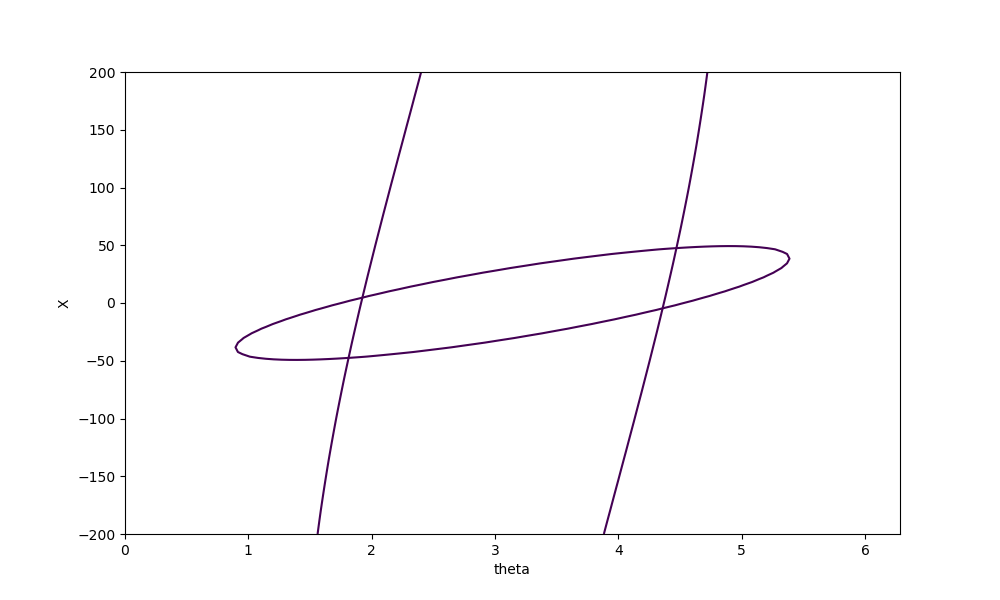

Text(0, 0.5, 'X')

In [97]:
V = Vs[1]
V_indeterminates = list(V.indeterminates())
V_indeterminates

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
# img = ax.scatter(TR1[success_indices], XR1[success_indices], alpha=0.2)
# img = ax.scatter(TR1_old[success_indices_old], XR1_old[success_indices_old], alpha=0.02)

TRV = np.linspace(0, 2*np.pi, 100)
XRV = np.linspace(-200, 200, 100)
TRV1, XRV1 = np.meshgrid(TRV, XRV)

Vplot = np.zeros_like(TRV1)

env = {}
for i in range(len(TRV1)):
    for j in range(len(TRV1[i])): 
        env[V_indeterminates[0]] = XRV1[i, j]
        env[V_indeterminates[1]] = 0
        env[V_indeterminates[2]] = 0
        env[V_indeterminates[3]] = np.sin(TRV1[i, j])
        env[V_indeterminates[4]] = np.cos(TRV1[i, j])
        Vplot[i, j] = V.Evaluate(env)

Vplot_old = np.zeros_like(TRV1)
env_old = {}
for i in range(len(TRV1)):
    for j in range(len(TRV1[i])): 
        env_old[V_old_indeterminates[0]] = XRV1[i, j]
        env_old[V_old_indeterminates[1]] = TRV1[i, j] - np.pi
        env_old[V_old_indeterminates[2]] = 0
        env_old[V_old_indeterminates[3]] = 0
        Vplot_old[i, j] = V_old.Evaluate(env_old)
        
ax.contour(TRV1,XRV1, Vplot, levels=[10])
ax.contour(TRV1,XRV1, Vplot_old, levels=[4005.9])
# ax.set_xlim(0, 2*np.pi)
# ax.set_ylim(-100, 100)
ax.set_xlabel("theta")
ax.set_ylabel("X")

In [55]:
z

array([Variable('x(0)', Continuous), Variable('t(0)', Continuous),
       Variable('\dot{x}(0)', Continuous),
       Variable('\dot{t}(0)', Continuous)], dtype=object)

In [48]:
prog = MathematicalProgram()
x = prog.NewIndeterminates(3, 'x')

In [49]:
u = prog.NewFreePolynomial(Variables(x), 2).ToExpression()

In [50]:
u

<Expression "(a(9) + (x(0) * x(1) * a(4)) + (x(0) * x(2) * a(3)) + (x(0) * a(8)) + (pow(x(0), 2) * a(5)) + (x(1) * x(2) * a(1)) + (x(1) * a(7)) + (pow(x(1), 2) * a(2)) + (x(2) * a(6)) + (pow(x(2), 2) * a(0)))">

In [52]:
list(Polynomial(u).indeterminates())

[Variable('x(0)', Continuous),
 Variable('x(1)', Continuous),
 Variable('x(2)', Continuous),
 Variable('a(0)', Continuous),
 Variable('a(1)', Continuous),
 Variable('a(2)', Continuous),
 Variable('a(3)', Continuous),
 Variable('a(4)', Continuous),
 Variable('a(5)', Continuous),
 Variable('a(6)', Continuous),
 Variable('a(7)', Continuous),
 Variable('a(8)', Continuous),
 Variable('a(9)', Continuous)]

In [69]:
# doing alternations in this form with controller search

def find_implicit_lambda_M(V, x, x_0, rho, M44, Mdot44, o, K2, B, X, z): 
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    
#     if o == 0: 
#         K2 = B.T@X@M44
#         u_arr = -K2@z
#         u = Polynomial(u_arr[0])
    
#     ggg = prog.NewContinuousVariables(1, 'ggg')[0]
        
    u = prog.NewFreePolynomial(Variables(x), 1)
    
    fz = np.array([x_pd[0], 
                  td[0], 
                  mp*l*td[0]**2*s[0] + u.ToExpression(),
                  -mp*gravity*l*s[0]])

    Vdotz = fz.T@P@M44@z + z.T@Mdot44.T@P@M44@z + z.T@M44.T@P@Mdot44@z + z.T@M44.T@P@fz
    Vdotz = Polynomial(Vdotz)

    Vdot = 0
    for m, coeff in Vdotz.monomial_to_coefficient_map().items(): 
        #display(Markdown("$ thing(x)="+ToLatex(coeff*m.ToExpression(), 9)+"$"))
        monomial = coeff
        for i in range(1, 3): 
            d = m.degree(x[i])
            monomial *= x[i]**d
        for i in range(len(z)):
            d = m.degree(z[i])
            if i==0:
                monomial*=x[0]**d
            if i==1:
                if d == 1:
                    monomial *= -x[1]
                elif d == 2:
                    monomial *= (2+2*x[2])
            elif i==2 or i==3:
                monomial *= x[i+1]**d
        for thing in list(u.decision_variables()): 
            d = m.degree(thing)
            monomial *= thing**d
        #display(Markdown("$ thing_changed(x)="+ToLatex(monomial, 9)+"$"))
        Vdot += monomial
    Vdot = Polynomial(Vdot)
    
    print(Vdot)
    
    l_deg = math.ceil(V.TotalDegree()/2) * 2
    s_deg = max(V.TotalDegree()-2, 0)
    
    lambda_trig = prog.NewFreePolynomial(Variables(x), s_deg)
    lambda_, lambda_Q = prog.NewSosPolynomial(Variables(x), l_deg)

    trig = Polynomial(x[1]**2 + x[2]**2)

    eps = 1e-5

    prog.AddSosConstraint(-Vdot - eps*Polynomial((x-x_0).dot(x-x_0)) +\
                          lambda_trig*trig+ \
                          lambda_*(V - rho))

    options = SolverOptions()
    options.SetOption(CommonSolverOption.kPrintFileName, './check_solver_cartpole.txt')
    options.SetOption(MosekSolver().solver_id(), "MSK_IPAR_NUM_THREADS", 0)

    solver = MosekSolver()
    result = solver.Solve(prog, solver_options=options)

    assert result.is_success(), str(result.get_solver_details().solution_status)
    
    lambda_sol = result.GetSolution(lambda_).RemoveTermsWithSmallCoefficients(1e-5)
    lambda_trig_sol = result.GetSolution(lambda_trig).RemoveTermsWithSmallCoefficients(1e-5)
    u_sol = result.GetSolution(u).RemoveTermsWithSmallCoefficients(1e-5)
    
    return lambda_sol, lambda_trig_sol, u_sol, 

def find_implicit_V_M(lambda_, lambda_trig, x, x_0, z, M44, Mdot44, fz, rho, P): 
    prog = MathematicalProgram()
    prog.AddIndeterminates(z)
    prog.AddIndeterminates(x[1:3])
    
    #rho = prog.NewContinuousVariables(1, 'rho')[0]
    
    S = prog.NewContinuousVariables(4, 4, 'S')
    #S = P
    
    Vz = Polynomial(z.T@M44.T@S@M44@z)
    V = 0
    for m, coeff in Vz.monomial_to_coefficient_map().items(): 
        #display(Markdown("$ thing(x)="+ToLatex(coeff*m.ToExpression(), 9)+"$"))
        monomial = coeff
        for i in range(1, 3): 
            d = m.degree(x[i])
            monomial *= x[i]**d
        for i in range(len(z)):
            d = m.degree(z[i])
            if i==0:
                monomial*=x[0]**d
            if i==1:
                if d == 1:
                    monomial *= -x[1]
                elif d == 2:
                    monomial *= (2+2*x[2])
            elif i==2 or i==3:
                monomial *= x[i+1]**d
        for i in range(len(S)): 
            for j in range(len(S[i])): 
                d = m.degree(S[i, j])
                monomial*=S[i, j]**d
        #display(Markdown("$ thing_changed(x)="+ToLatex(monomial, 9)+"$"))
        V += monomial
        
    V = Polynomial(V)
    
    Vdotz = fz.T@S@M44@z + z.T@Mdot44.T@S@M44@z + z.T@M44.T@S@Mdot44@z + z.T@M44.T@S@fz
    Vdotz = Polynomial(Vdotz)
    
    Vdot = 0
    for m, coeff in Vdotz.monomial_to_coefficient_map().items(): 
        #display(Markdown("$ thing(x)="+ToLatex(coeff*m.ToExpression(), 9)+"$"))
        monomial = coeff
        for i in range(1, 3): 
            d = m.degree(x[i])
            monomial *= x[i]**d
        for i in range(len(z)):
            d = m.degree(z[i])
            if i==0:
                monomial*=x[0]**d
            if i==1:
                if d == 1:
                    monomial *= -x[1]
                elif d == 2:
                    monomial *= (2+2*x[2])
            elif i==2 or i==3:
                monomial *= x[i+1]**d
        for i in range(len(S)): 
            for j in range(len(S[i])): 
                d = m.degree(S[i, j])
                monomial*=S[i, j]**d
        #display(Markdown("$ thing_changed(x)="+ToLatex(monomial, 9)+"$"))
        Vdot += monomial
        
    Vdot = Polynomial(Vdot)
    
    trig = Polynomial(x[1]**2 + x[2]**2)
    eps = 1e-5
    
    
    prog.AddSosConstraint(-Vdot - eps*Polynomial((x-x_0).dot(x-x_0)) + \
                          lambda_trig*trig + \
                          lambda_*(V - rho))
    
    prog.AddLinearConstraint(V.ToExpression().Substitute({x[0]:0, x[1]:0, x[2]:-1, x[3]:0, x[4]:0}) == 0)
    
    prog.AddLinearCost(np.trace(S))
    
    lambda_trig_enforcer = prog.NewFreePolynomial(Variables(x), 2)
    prog.AddSosConstraint(V + lambda_trig_enforcer*trig)
    
    prog.AddPositiveSemidefiniteConstraint(S)
    
    options = SolverOptions()
    options.SetOption(CommonSolverOption.kPrintFileName, './check_solver_cartpole.txt')

    solver = MosekSolver()
    result = solver.Solve(prog, solver_options=options)

    assert result.is_success(), str(result.get_solver_details().solution_status)
    
#     V_sol = result.GetSolution(V)
#     Vdot_sol = result.GetSolution(Vdot_sol)

    S_sol = result.GetSolution(S)
    
    return S_sol


def implicit_M_solver(P, B, X): 
    prog = MathematicalProgram()
    x_p = prog.NewIndeterminates(1, "x")
    t = prog.NewIndeterminates(1, "t")
    x_pd = prog.NewIndeterminates(1, "\dot{x}")
    td = prog.NewIndeterminates(1, "\dot{t}")
    s = prog.NewIndeterminates(1, "s")
    c = prog.NewIndeterminates(1, "c")

    rho = prog.NewContinuousVariables(1, 'rho')[0]
    alpha = prog.NewContinuousVariables(1, 'alpha')[0]

    x = np.hstack([x_p, s, c, x_pd, td])
    x_0 = np.array([0, 0, -1, 0, 0])
    z = np.hstack([x_p, t, x_pd, td])

    M44 = np.array([[1, 0, 0, 0], 
                 [0, 1, 0, 0], 
                 [0, 0, mc+mp, l*mp*c[0]], 
                 [0, 0, l*mp*c[0], l**2*mp]])

    Mdot44 = np.array([[0, 0, 0, 0], 
                 [0, 0, 0, 0], 
                 [0, 0, 0, -l*mp*s[0]*td[0]], 
                 [0, 0, -l*mp*s[0]*td[0], 0]])

    Vz = Polynomial(z.T@M44.T@P@M44@z)

    V = 0
    for m, coeff in Vz.monomial_to_coefficient_map().items(): 
        #display(Markdown("$ thing(x)="+ToLatex(coeff*m.ToExpression(), 9)+"$"))
        monomial = coeff
        for i in range(1, 3): 
            d = m.degree(x[i])
            monomial *= x[i]**d
        for i in range(len(z)):
            d = m.degree(z[i])
            if i==0:
                monomial*=x[0]**d
            if i==1:
                if d == 1:
                    monomial *= -x[1]
                elif d == 2:
                    monomial *= (2+2*x[2])
            elif i==2 or i==3:
                monomial *= x[i+1]**d
        #display(Markdown("$ thing_changed(x)="+ToLatex(monomial, 9)+"$"))
        V += monomial

    V = Polynomial(V).RemoveTermsWithSmallCoefficients(1e-5)

#     K2 = B.T@X@M44
#     u = -K2@z
    
    rho = 172
    Vs = []
    for o in range(1): 
        lambda_, lambda_trig, u_sol = find_implicit_lambda_M(V, x, x_0, rho, M44, Mdot44, o, K2, B, X, z)
        
        fz = np.array([x_pd[0], 
                  td[0], 
                  mp*l*td[0]**2*s[0] + u_sol.ToExpression(),
                  -mp*gravity*l*s[0]])
        
        S_sol = find_implicit_V_M(lambda_, lambda_trig, x, x_0, z, M44, Mdot44, fz, rho, P)
        
        Vz = Polynomial(z.T@M44.T@S_sol@M44@z)

        V = 0
        for m, coeff in Vz.monomial_to_coefficient_map().items(): 
            #display(Markdown("$ thing(x)="+ToLatex(coeff*m.ToExpression(), 9)+"$"))
            monomial = coeff
            for i in range(1, 3): 
                d = m.degree(x[i])
                monomial *= x[i]**d
            for i in range(len(z)):
                d = m.degree(z[i])
                if i==0:
                    monomial*=x[0]**d
                if i==1:
                    if d == 1:
                        monomial *= -x[1]
                    elif d == 2:
                        monomial *= (2+2*x[2])
                elif i==2 or i==3:
                    monomial *= x[i+1]**d
            #display(Markdown("$ thing_changed(x)="+ToLatex(monomial, 9)+"$"))
            V += monomial

        V = Polynomial(V)

        Vdotz = fz.T@S_sol@M44@z + z.T@Mdot44.T@S_sol@M44@z + z.T@M44.T@S_sol@Mdot44@z + z.T@M44.T@S_sol@fz
        Vdotz = Polynomial(Vdotz)

        Vdot = 0
        for m, coeff in Vdotz.monomial_to_coefficient_map().items(): 
            #display(Markdown("$ thing(x)="+ToLatex(coeff*m.ToExpression(), 9)+"$"))
            monomial = coeff
            for i in range(1, 3): 
                d = m.degree(x[i])
                monomial *= x[i]**d
            for i in range(len(z)):
                d = m.degree(z[i])
                if i==0:
                    monomial*=x[0]**d
                if i==1:
                    if d == 1:
                        monomial *= -x[1]
                    elif d == 2:
                        monomial *= (2+2*x[2])
                elif i==2 or i==3:
                    monomial *= x[i+1]**d
            #display(Markdown("$ thing_changed(x)="+ToLatex(monomial, 9)+"$"))
            Vdot += monomial
        Vdot = Polynomial(Vdot)
        
        Vs.append(V)
        
        print(o)
        print(S_sol)
        
    return V, Vdot, S_sol, Vs
        
V, Vdot, S_sol, Vs = implicit_M_solver(P, B, X)

528.84265701061008*s(0) + -2.5876366893405498*s(0) * a(5) + -2.5876366893405498*s(0) * c(0) * a(0) + -2.5876366893405498*s(0)^2 * a(1) + -126.74380513371976*\dot{t}(0) + 0.62876884590590931*\dot{t}(0) * a(5) + -5.0129043356820482*\dot{t}(0) * c(0) + 0.026651785067781708*\dot{t}(0) * c(0) * a(5) + 0.62876884590590931*\dot{t}(0) * c(0) * a(0) + 0.026651785067781708*\dot{t}(0) * c(0)^2 * a(0) + -2.5876366893405498*\dot{t}(0) * s(0) * a(2) + 0.62876884590590931*\dot{t}(0) * s(0) * a(1) + 0.026651785067781708*\dot{t}(0) * s(0) * c(0) * a(1) + 0.62876884590590931*\dot{t}(0)^2 * a(2) + 0.026651785067781708*\dot{t}(0)^2 * c(0) * a(2) + 1.2938183446702749*\dot{t}(0)^2 * s(0)^2 + -0.31438442295295466*\dot{t}(0)^3 * s(0) + -0.013325892533890854*\dot{t}(0)^3 * s(0) * c(0) + -110.28389538500505*\dot{x}(0) + 0.58633927149119758*\dot{x}(0) * a(5) + -253.48761026743952*\dot{x}(0) * c(0) + 1.2575376918118186*\dot{x}(0) * c(0) * a(5) + 0.58633927149119758*\dot{x}(0) * c(0) * a(0) + 1.2575376918118186*\d

AssertionError: 5

### Plotting

In [125]:
success_indices = np.where(success_list == 1)

In [66]:
success_list_old = np.load('cartpole300by300.npy')
XR_old = np.linspace(-50, 50, 300)
TR_old = np.linspace(np.pi - 0.5*np.pi, np.pi+0.5*np.pi, 300)
XR1_old, TR1_old = np.meshgrid(XR_old, TR_old)
success_indices_old = np.where(success_list_old == 1)
fail_indices_old = np.where(success_list_old == 0)

In [67]:
success_list = np.load('cartpole100by100_new.npy')
XR = np.linspace(-50, 50, 100)
TR = np.linspace(np.pi - 0.5*np.pi, np.pi+0.5*np.pi, 100)
XR1, TR1 = np.meshgrid(XR, TR)
success_indices = np.where(success_list == 1)
fail_indices = np.where(success_list == 0)

In [149]:
V_indeterminates = list(V.indeterminates())
V_indeterminates

[Variable('x(0)', Continuous),
 Variable('\dot{x}(0)', Continuous),
 Variable('\dot{t}(0)', Continuous),
 Variable('s(0)', Continuous),
 Variable('c(0)', Continuous)]

In [150]:
V_old = Polynomial(z.T@E.T@P@E@z)
V_old_indeterminates = list(V_old.indeterminates())
V_old_indeterminates

[Variable('x(0)', Continuous),
 Variable('t(0)', Continuous),
 Variable('\dot{x}(0)', Continuous),
 Variable('\dot{t}(0)', Continuous)]

In [151]:
V_old.Evaluate({x_p[0]:0, t[0]:0, x_pd[0]:0, td[0]:0})

0.0

<IPython.core.display.Javascript object>


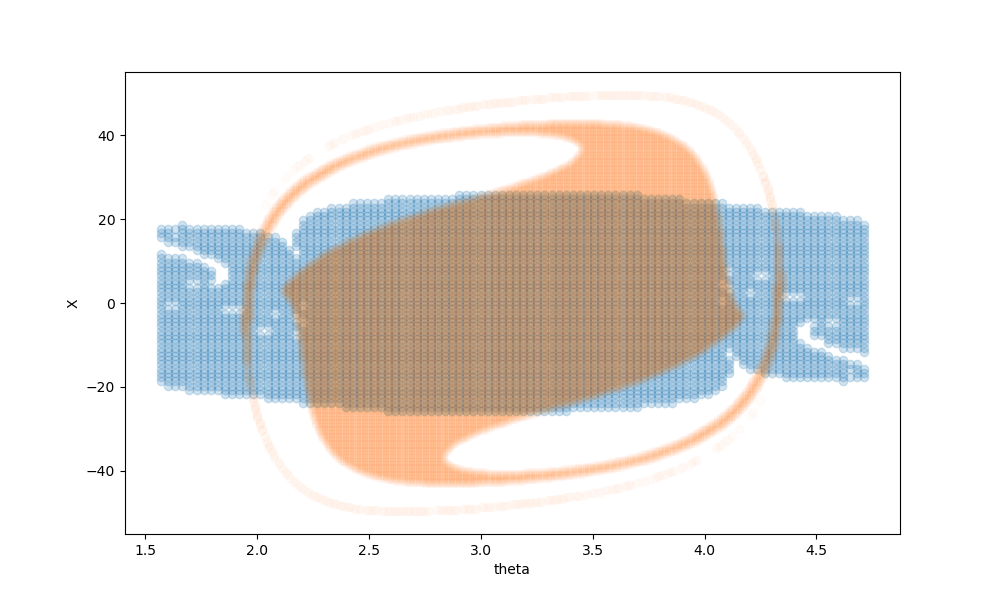

/tmp/ipykernel_85332/3368791063.py:33: UserWarning: No contour levels were found within the data range.
  ax.contour(TR1,XR1, Vplot, levels=[172.5])


Text(0, 0.5, 'X')

In [154]:

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

img = ax.scatter(TR1[success_indices], XR1[success_indices], alpha=0.2)
img = ax.scatter(TR1_old[success_indices_old], XR1_old[success_indices_old], alpha=0.02)

#img = ax.scatter(TR1[fail_indices], XR1[fail_indices], alpha=0.2)

# img = ax.scatter(TR1[success_indices_new], TR2[success_indices_new], alpha=0.2)

Vplot = np.zeros_like(TR1)

env = {}
for i in range(len(TR1)):
    for j in range(len(TR1[i])): 
        env[V_indeterminates[0]] = XR1[i, j]
        env[V_indeterminates[1]] = 0
        env[V_indeterminates[2]] = 0
        env[V_indeterminates[3]] = np.sin(TR1[i, j])
        env[V_indeterminates[4]] = np.cos(TR1[i, j])
        Vplot[i, j] = V.Evaluate(env)

Vplot_old = np.zeros_like(TR1)
env_old = {}
for i in range(len(TR1)):
    for j in range(len(TR1[i])): 
        env_old[V_old_indeterminates[0]] = XR1[i, j]
        env_old[V_old_indeterminates[1]] = TR1[i, j] - np.pi
        env_old[V_old_indeterminates[2]] = 0
        env_old[V_old_indeterminates[3]] = 0
        Vplot_old[i, j] = V_old.Evaluate(env_old)
        
ax.contour(TR1,XR1, Vplot, levels=[172.5])
#ax.contour(TR1,XR1, Vplot_old, levels=[30])
# ax.set_xlim(0, 2*np.pi)
# ax.set_ylim(-100, 100)
ax.set_xlabel("theta")
ax.set_ylabel("X")

In [69]:
np.linalg.eigvals(E.T@P@E)

array([3.18039005e+03, 1.78899263e+00, 1.94606501e-01, 3.91789703e-01])

In [95]:
end_time

3520.7027587890625

In [123]:
np.save('cartpole300by300.npy', success_list)

In [26]:
def cartpole_balancing_example():
    def UprightState():
        state = (0, np.pi, 0, 0)
        return state

    def Linearized_Matrices(plant):
        print('HERE')
        context = plant.CreateDefaultContext()
        plant.get_actuation_input_port().FixValue(context, [0])
        plant.SetPositionsAndVelocities(context, UprightState())

        linearized_plant = Linearize(
            plant,
            context,
            input_port_index=plant.get_actuation_input_port().get_index(), output_port_index=plant.get_state_output_port().get_index())
        print(linearized_plant.A())
        print(linearized_plant.B())

    def BalancingLQR(plant):
        # Design an LQR controller for stabilizing the CartPole around the upright.
        # Returns a (static) AffineSystem that implements the controller (in
        # the original CartPole coordinates).

        context = plant.CreateDefaultContext()
        plant.get_actuation_input_port().FixValue(context, [0])

        plant.SetPositionsAndVelocities(context, UprightState())

        Q = np.diag((10., 10., 1., 1.))
        R = np.array([1])

        # MultibodyPlant has many (optional) input ports, so we must pass the
        # input_port_index to LQR.
        return LinearQuadraticRegulator(
            plant,
            context,
            Q,
            R,
            input_port_index=plant.get_actuation_input_port().get_index())

    u = -K@(x  - UprightState())
    own_controller = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u)
    
    u2 = -K2@(x - UprightState())
    own_controller_new = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=u2)
    
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.1)
    file_name = FindResource("models/cartpole.urdf")
    Parser(plant).AddModelFromFile(file_name)
    plant.Finalize()
#     print('HERE')
    Linearized_Matrices(plant)
    
    wrapangles = WrapToSystem(4)
    wrapangles.set_interval(1, 0, 2*np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(plant.get_state_output_port(), wrapto.get_input_port())
    
    #controller = builder.AddSystem(BalancingLQR(plant))
    controller = builder.AddSystem(own_controller)
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), plant.get_actuation_input_port())
    
    logger = LogVectorOutput(wrapto.get_output_port(), builder)

#     # Setup visualization
#     meshcat.Delete()
#     meshcat.Set2dRenderMode(xmin=-2.5, xmax=2.5, ymin=-1.0, ymax=2.5)
#     MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    plant_context = plant.GetMyMutableContextFromRoot(context)

    # Simulate
    simulator.set_target_realtime_rate(0)
    duration = 60
    for i in range(1):
        context.SetTime(0.)
    #     plant.SetPositionsAndVelocities(
    #         plant_context,
    #         UprightState() + 0.9 * np.random.randn(4,))
        trial = np.append(UprightState(), 0) - 0.1*np.random.randn(5)
        trial = np.array([500, -4, 0, 0])
        print(trial)
        plant.SetPositionsAndVelocities(
            plant_context, trial)
        simulator.Initialize()
        simulator.AdvanceTo(duration)

        log = logger.FindLog(context)

        end_state = log.data()[:, -1]
        diff = np.abs(end_state - UprightState())
        plt.figure(figsize=(5, 4))
        plt.plot(log.sample_times(), log.data().transpose())
        plt.xlabel('t')
        plt.ylabel('y(t)')

#np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})
cartpole_balancing_example()

HERE
[[1.       0.00981  0.1      0.      ]
 [0.       1.021582 0.       0.1     ]
 [0.       0.0981   1.       0.      ]
 [0.       0.21582  0.       1.      ]]
[[1.e-04]
 [2.e-05]
 [1.e-03]
 [2.e-04]]
[500  -4   0   0]


RuntimeError: Detected NaN in the actuation input port for all instances.

In [81]:
np.rad2deg(5.1)

292.20847551671983

Doing stereographic projections

In [63]:
from pydrake.examples.acrobot import (AcrobotGeometry, AcrobotInput,
                                      AcrobotPlant, AcrobotState, AcrobotParams)
from pydrake.all import Linearize, LinearQuadraticRegulator, SymbolicVectorSystem, Variable, Saturation, \
WrapToSystem, Simulator, Polynomial

from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

from IPython.display import SVG, display
import pydot
import numpy as np
import math
import control

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import pydrake.forwarddiff as pf
import time

from IPython.display import display, Math, Markdown
from pydrake.examples.pendulum import PendulumPlant
from pydrake.examples.acrobot import AcrobotPlant
from pydrake.all import MultibodyPlant, Parser, SinCos, MakeVectorVariable, ToLatex, Substitute, Box
from underactuated import FindResource
from underactuated.scenarios import AddShape

from pydrake.all import (Jacobian, MathematicalProgram, Polynomial,
                         RegionOfAttraction, RegionOfAttractionOptions, Solve,
                         SymbolicVectorSystem, ToLatex, Variable, Variables,
                         plot_sublevelset_expression, AddMultibodyPlantSceneGraph, SolverOptions, 
                         CommonSolverOption)

from pydrake.solvers.mosek import MosekSolver
import sympy as sp
from sympy.physics.vector import dynamicsymbols as dynamicsymbols

In [64]:
mc = 10
mp = 1
l = 0.5
gravity = 9.81

In [65]:
prog_create = MathematicalProgram()
x = prog_create.NewIndeterminates(4, 'X')
xd = prog_create.NewIndeterminates(4, 'Xd')
u = prog_create.NewIndeterminates(1, 'u')

dynamics = np.array([[xd[0] - x[2]], 
                     [xd[1] - (1 + x[1]**2)*x[3]/2], 
                     [(1 + x[1]**2)*(mc + mp)*xd[2] - mp*l*(1 - x[1]**2)*xd[3] \
                      + 2*mp*l*x[1]*x[3]**2 - (1 + x[1]**2)*u[0]], 
                     [-mp*l*(1 - x[1]**2)*xd[2] + mp*l**2*(1 + x[1]**2)*xd[3] - mp*gravity*l*2*x[1]]])

M = np.array([[1, 0, 0, 0], 
              [0, 1, 0, 0], 
              [0, 0, (1 + x[1]**2)*(mc+mp), -mp*l*(1 - x[1]**2)], 
              [0, 0, -mp*l*(1 - x[1]**2), mp*l**2*(1 + x[1]**2)]])

p_dot = 0.5*(1 + x[1]**2)*x[3]

Mdot = np.array([[0, 0, 0, 0], 
              [0, 0, 0, 0], 
              [0, 0, (x[1]*2)*(mc+mp)*p_dot, 2*mp*l*x[1]*p_dot], 
              [0, 0, 2*mp*l*x[1]*p_dot, 2*mp*l**2*x[1]*p_dot]])

f = np.array([[x[2] + 0], 
              [(1 + x[1]**2)*x[3]/2], 
              [- 2*mp*l*x[1]*x[3]**2 + (1 + x[1]**2)*u[0]], 
              [mp*gravity*l*2*x[1]]])

env = {x[0]:0, x[1]:0, x[2]:0, x[3]:0, xd[0]:0, xd[1]:0, xd[2]:0, xd[3]:0, u[0]:0}
A_general = []
for exp in f: 
    exp_curr = exp[0].Jacobian(x)
    A_general.append(exp_curr)
A_general = np.array(A_general)  

A = np.zeros_like(A_general)
for i, row in enumerate(A_general): 
    for j, elem in enumerate(row): 
        A[i, j] = elem.Evaluate(env)
        
A = np.array(A, dtype=float)

E_general = []
for exp in dynamics: 
    exp_curr = exp[0].Jacobian(xd)
    E_general.append(exp_curr)
E_general = np.array(E_general)  

E = np.zeros_like(E_general)
for i, row in enumerate(E_general): 
    for j, elem in enumerate(row): 
        E[i, j] = elem.Evaluate(env)
        
E = np.array(E, dtype=float)

B = np.array([[0], 
              [0], 
              [1], 
              [0]])

In [66]:
Q = np.diag([10, 10, 0, 0])
R = [1]

X, L, K = control.care(A, B, Q, R, E=E)

In [67]:
K

array([[ -3.16227766, 508.19361218,  -9.70810764,  55.10499085]])

In [68]:
A_cloop = A - B@K
Q_lyap = np.eye(4)

P = control.lyap(A_cloop.T, Q_lyap, E=E.T)

np.linalg.eigvals(P)

array([3.56131853e+02, 1.30005328e+00, 1.71739920e+00, 1.16587049e-03])

In [69]:
V = x.T@M.T@P@M@x
V = Polynomial(V)

In [70]:
u = -K@x

f = np.array([[x[2] + 0], 
              [(1 + x[1]**2)*x[3]/2], 
              [- 2*mp*l*x[1]*x[3]**2 + (1 + x[1]**2)*u[0]], 
              [mp*gravity*l*2*x[1]]])

Vdot = f.T@P@M@x + x.T@Mdot.T@P@M@x + x.T@M.T@P@Mdot@x + x.T@M.T@P@f
Vdot = Polynomial(Vdot[0])

In [71]:
a1 = Vdot.Jacobian(x)

Vdot_Hessian = []
for element in a1: 
    Vdot_Hessian.append(element.Jacobian(x))
Vdot_Hessian = np.array(Vdot_Hessian)

env = {x[0]:0, x[1]:0, x[2]:0, x[3]:0, xd[0]:0, xd[1]:0, xd[2]:0, xd[3]:0}

Vdot_Hessian_origin = np.zeros_like(Vdot_Hessian)

for i in range(len(Vdot_Hessian)): 
    for j in range(len(Vdot_Hessian[i])): 
        Vdot_Hessian_origin[i, j] = Vdot_Hessian[i, j].Evaluate(env)
        
Vdot_Hessian_origin = np.array(Vdot_Hessian_origin, dtype=float)

np.linalg.eigvals(Vdot_Hessian_origin)

array([-2., -2., -2., -2.])

In [72]:
Vdot.TotalDegree()

8

In [117]:
prog = MathematicalProgram()
prog.AddIndeterminates(x)

rho = prog.NewContinuousVariables(1, 'rho')[0]

l_deg = 4
lambda_, _ = prog.NewSosPolynomial(Variables(x), l_deg)

rho = 0.87
#prog.AddSosConstraint(Polynomial(x.dot(x))*(V - rho) - lambda_*Vdot)

prog.AddSosConstraint(-Vdot + lambda_*(V - rho))
#prog.AddCost(-rho)

solver = MosekSolver()
result = solver.Solve(prog)

assert result.is_success(), str(result.get_solver_details().solution_status)

In [158]:
def find_lambda(V, Vdot, x, rho): 
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    
    l_deg = 4
    lambda_, _ = prog.NewSosPolynomial(Variables(x), l_deg)
    
    prog.AddSosConstraint(-Vdot + lambda_*(V - rho))
    
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    assert result.is_success(), str(result.get_solver_details().solution_status)
    
    lambda_sol = result.GetSolution(lambda_)
    
    return lambda_sol.RemoveTermsWithSmallCoefficients(1e-5)

def find_V(lambda_, rho, x, M, Mdot, f): 
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    
    f_new = np.copy(f)
    
    u = prog.NewFreePolynomial(Variables(x), 1)
    f_new[2] = - 2*mp*l*x[1]*x[3]**2 + (1 + x[1]**2)*u.ToExpression()
    
    print(f_new)
    S = prog.NewSymmetricContinuousVariables(4, 'S')
    
    V = x.T@M.T@S@M@x
    Vdot = f_new.T@S@M@x + x.T@Mdot.T@S@M@x + x.T@M.T@S@Mdot@x + x.T@M.T@S@f_new
    Vdot = Vdot[0]
    
    V = Polynomial(V)
    Vdot = Polynomial(Vdot)
    print(V.indeterminates())
    print(Vdot.indeterminates())
    prog.AddSosConstraint(-Vdot + lambda_*(V - rho))
    
    prog.AddCost(np.trace(S))
    prog.AddPositiveSemidefiniteConstraint(S)
    
    solver = MosekSolver()
    result = solver.Solve(prog)
    
    assert result.is_success(), str(result.get_solver_details().solution_status)
    
    S_sol = result.GetSolution(S)
    u_sol = result.GetSolution(u)
    
    return S_sol, u_sol
    
def set_up_alternations(M, Mdot, f, x, P, rho): 
    prog = MathematicalProgram()
    prog.AddIndeterminates(x)
    
    V = x.T@M.T@P@M@x
    Vdot = f.T@P@M@x + x.T@Mdot.T@P@M@x + x.T@M.T@P@Mdot@x + x.T@M.T@P@f
    
    V = Polynomial(V)
    Vdot = Polynomial(Vdot[0])
    
    for i in range(1): 
        lambda_ = find_lambda(V, Vdot, x, rho)
        S, u_sol = find_V(lambda_, rho, x, M, Mdot, f)
        
        V = x.T@M.T@S@M@x
        Vdot = f.T@S@M@x + x.T@Mdot.T@S@M@x + x.T@M.T@S@Mdot@x + x.T@M.T@S@f
        V = Polynomial(V).RemoveTermsWithSmallCoefficients(1e-5)
        Vdot = Polynomial(Vdot[0]).RemoveTermsWithSmallCoefficients(1e-5)
        
        print(i)
        print(S)
    
    return S, V, Vdot

S, V, Vdot = set_up_alternations(M, Mdot, f, x, P, 0.8)

[[<Expression "X(2)">]
 [<Expression "((X(3) * (1 + pow(X(1), 2))) / 2)">]
 [<Expression "( - (X(1) * pow(X(3), 2)) + ((a(4) + (X(0) * a(3)) + (X(1) * a(2)) + (X(2) * a(1)) + (X(3) * a(0))) * (1 + pow(X(1), 2))))">]
 [<Expression "(9.8100000000000005 * X(1))">]]
{X(0), X(1), X(2), X(3), S(0,0), S(1,0), S(2,0), S(3,0), S(1,1), S(2,1), S(3,1), S(2,2), S(3,2), S(3,3)}
{X(0), X(1), X(2), X(3), a(0), a(1), a(2), a(3), a(4), S(0,0), S(1,0), S(2,0), S(3,0), S(1,1), S(2,1), S(3,1), S(2,2), S(3,2), S(3,3)}


RuntimeError: Expression ( - (a(4) * S(2,2)) + 0.5 * (a(4) * S(3,2))) is non-linear.

In [152]:
np.linalg.eigvals(S)

array([4.40480639e+00, 3.19077045e-01, 4.80615758e-03, 1.00303140e-04])

<IPython.core.display.Javascript object>


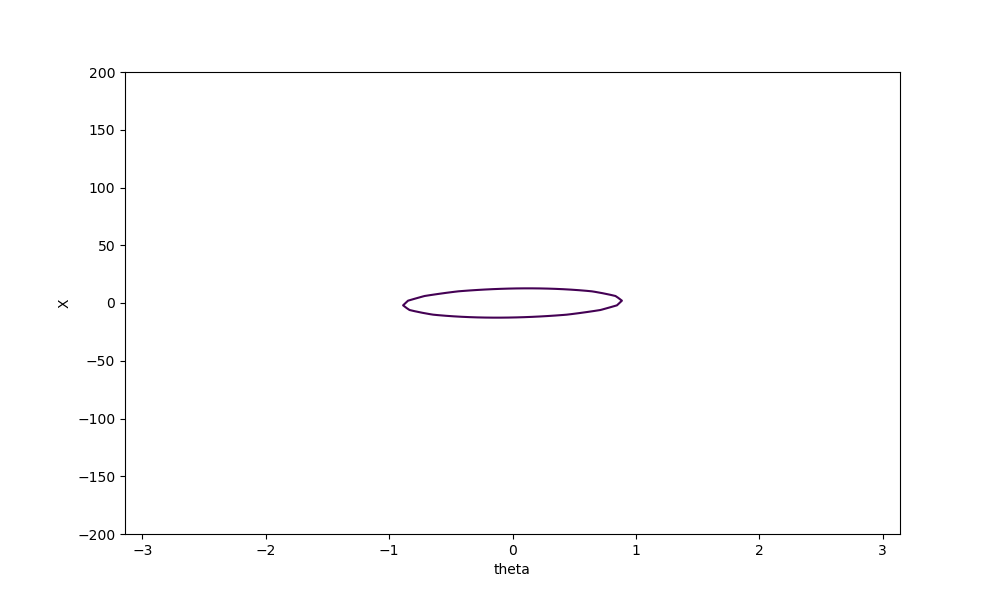

Text(0, 0.5, 'X')

In [153]:
V_indeterminates = list(V.indeterminates())
V_indeterminates

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
# img = ax.scatter(TR1[success_indices], XR1[success_indices], alpha=0.2)
# img = ax.scatter(TR1_old[success_indices_old], XR1_old[success_indices_old], alpha=0.02)

TRV = np.linspace(-np.pi, np.pi, 100)
XRV = np.linspace(-200, 200, 100)
TRV1, XRV1 = np.meshgrid(TRV, XRV)

Vplot = np.zeros_like(TRV1)

env = {}
for i in range(len(TRV1)):
    for j in range(len(TRV1[i])): 
        env[V_indeterminates[0]] = XRV1[i, j]
        env[V_indeterminates[1]] = TRV1[i, j]/2
        env[V_indeterminates[2]] = 0
        env[V_indeterminates[3]] = 0
        Vplot[i, j] = V.Evaluate(env)

# Vplot_old = np.zeros_like(TRV1)
# env_old = {}
# for i in range(len(TRV1)):
#     for j in range(len(TRV1[i])): 
#         env_old[V_old_indeterminates[0]] = XRV1[i, j]
#         env_old[V_old_indeterminates[1]] = TRV1[i, j] - np.pi
#         env_old[V_old_indeterminates[2]] = 0
#         env_old[V_old_indeterminates[3]] = 0
#         Vplot_old[i, j] = V_old.Evaluate(env_old)
        
ax.contour(TRV1,XRV1, Vplot, levels=[0.8])
# ax.contour(TRV1,XRV1, Vplot_old, levels=[4005.9])
# ax.set_xlim(0, 2*np.pi)
# ax.set_ylim(-100, 100)
ax.set_xlabel("theta")
ax.set_ylabel("X")